In [1238]:
def restart_runtime():
  os.kill(os.getpid(), 9)

In [1239]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

!pip install tensorflow==2.8
import tensorflow as tf

tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE

!pip install tensorflow-datasets==4.1.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt
import random

print("Tensorflow version {}".format(tf.__version__))

Tensorflow version 2.8.0


In [1240]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


In [1241]:
ATTEMPT = 1
# Maximum sentence length
MAX_LENGTH = 50

# Maximum number of samples to preprocess
MAX_SAMPLES =0 # 0 = for All of data otherwise mention the size

# Cut off value of words in the dictionary
TRESHOLD_VALUE = 1

# For tf.data.Dataset
BATCH_SIZE =8 * strategy.num_replicas_in_sync
BUFFER_SIZE = 1000 #Shuffle data in the dataset

# For Transformer
NUM_LAYERS = 2
D_MODEL = 512
NUM_HEADS = 16
UNITS = 512
DROPOUT = 0.3

EPOCHS =150
TRAINING_RATIO = 0.9

In [1242]:
import pandas as pd

data_set_url = 'sample_data/sep10.csv'
b_data=pd.read_csv( data_set_url , header = None)
b_data=b_data.astype(str)
# b_data.drop(b_data.columns[[1]], axis = 1, inplace = True)
if MAX_SAMPLES == 0 or len(b_data[:][1:]) < MAX_SAMPLES:
  b_data = b_data[:][1:]
else:
  b_data = b_data[:][1:MAX_SAMPLES]
print("Number of data :" + str(len(b_data)))

Number of data :4445


In [1243]:
questions = b_data[0].tolist()
answers = b_data[1].tolist()

In [1244]:
for i in random.sample(range(1, 1000), 4):
  print("Question :"+questions[i] + "   Answer :"+answers[i])

Question :මම කවදාවත් ඉපදුනේ නැද්ද කියලා ප්‍රාර්ථනා කරනවා. මට හැඟෙන ආකාරය පිළිබඳ යම් ඉදිරිදර්ශනයක් ලබා ගැනීමට බලාපොරොත්තු වන දීප්තිමත් පැත්ත දෙස බැලීමට අවධානය හෝ උපදෙස් සොයන්නේ නැත. සමහර විට මනෝවිද්‍යාත්මකව මේ ආකාරයෙන් දැනීම යන්නෙන් අදහස් කරන්නේ කුමක්ද? මගේ මුළු ජීවිත කාලයම මට දැනුණේ කළු බැටළුවා වගේ. මම කවදාවත් කොහෙවත් ඇත්තටම ගැලපෙන්නේ නැහැ. මම කවදාවත් ඉපදුනේ නැද්ද කියලා මම කැමතියි. මම කිසිවකුගේ ජීවිතයට බලපෑමක් කර නැති බවත්, එසේ කළේ නම් එය ඍණාත්මක හෝ නොපවතින බවත් මට හැඟේ. මට අරමුණක් ඇති බව මට හැඟිය යුතුය. මම කසාද බැඳලා අවුරුදු 6කට පස්සේ ළමයි දෙන්නෙක් ඒත් මම මැරුණොත් කවුද බලාගන්නේ? ලෝකය වෙනස් වන්නේ කෙසේද. මම මගේ ස්වාමිපුරුෂයාට මේ ගැන කතා කළා (ඔහුගේ ජීවිතය යහපත් අතට හැරවීමට මා බලපෑ බව දැන ගැනීමෙන් යම් සහනයක් ලබා ගැනීමට බලාපොරොත්තු වෙනවාද?) මෙය ඔහුගේ නිවැරදි වචන විය ඔව් හොඳයි, ඔබ එය එසේ යැයි සිතන්නේ කෙසේදැයි මම දකිමි. එය මාව බිඳ දැමූ අතර එය මගේ අදහස වලංගු කරන බවක් දැනුනි. මේ ජීවිතය ජීවිතය සිරගෙයක් ලෙස දැනේ. මම කොතැනකට ගියත් එය ඇත්තෙන්ම වැදගත් නොවන බව දැන ගැනීම වටිනාකමක් නැති සහ අසනීප බවක් 

In [1245]:
len(answers)

4445

In [1246]:
# -*- coding: utf-8 -*-
import re


class SinhalaPreprocessor:

    @classmethod
    def preprocess_sentence(cls, sentence):
        # Remove English words and numbers
        sentence = re.sub(r"[a-zA-Z0-9]+", "", sentence)
        # Define the pattern for unwanted characters
        unwanted_chars = re.sub(r"[¡©±³·º¿¿ÃÂ¡áéñóúüÃâ€““”‘’óœد]+", "", sentence)
        # There are some &quote while the words
        sentence = re.sub(r"&quot", " ", sentence)
        # - and long hypen should replace with space
        sentence = re.sub(r"([\-–])", " ", sentence)
        # stripe "  සිංහල    භාෂාව " => " සිංහල භාෂාව "
        sentence = sentence.strip()
        # 40,000 -> 40000
        sentence = re.sub(r",000", r"000", sentence)
        # <u>නැගෙනහිර යුරෝපය</u> => නැගෙනහිර යුරෝපය U can be simple or capital
        # Here anything could be between the tag
        sentence = re.sub(r"(<.*?>)+(.*?)(<.*?>)*", r" \2 ", sentence)
        # Here I consider ? . ! , as single words
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        # 100ක් -> 100 ක්
        sentence = re.sub(r"([\d]+)", r" \1 ", sentence)
        # remove `~@#$%^&*()_+=/><':;}{[]|\ “‘
        sentence = re.sub(r"([“‘`~@#$%^&*()_+=/><':;}{\[\]\\|])", "", sentence)
        # remove double quotes
        sentence = re.sub(r'[" "]+', " ", sentence)
        return sentence

    @classmethod
    def preprocess_sentences(cls, sentences):
        new_sentences = []
        for sentence in sentences:
            new_sentences.append(cls.preprocess_sentence(sentence))
        return new_sentences

# u([\u0D80-\u0DFF]+)u - to recognize sinhala words

In [1247]:
# @title
sinhala_pre = SinhalaPreprocessor()
questions = sinhala_pre.preprocess_sentences(questions)
answers = sinhala_pre.preprocess_sentences(answers)
# questions = sinhala_pre.preprocess_sentences(questions)

In [1248]:
import math

training_len = math.floor(len(questions)*TRAINING_RATIO)

train_questions = questions[:training_len]
train_answers = answers[:training_len]

test_questions = questions[training_len:]
test_answers = answers[training_len:]

In [1249]:
len(train_questions)

4000

In [1250]:
len(questions)

4445

In [1251]:
print('Sample question: {}'.format(train_questions[20]))
print('Sample answer: {}'.format(train_answers[20]))

Sample question: නේවාසික ප්‍රතිකාර සොයා ගැනීමට මට යා හැක්කේ කොතැනටද ? 
Sample answer: ඔබ හෝ ඔබ දන්නා අයෙක් අර්බුදයක සිටී නම් , නේවාසික රෝගීන්ට උපකාර කළ හැකිය . නේවාසික රෝගීන්ට නව ඖෂධ මත ස්ථාවර වීමට , නව රෝග ලක්ෂණ වලට හැඩගැසීමට හෝ ඔවුන්ට අවශ්ය උපකාර ලබා ගැනීමට උපකාර කළ හැකිය . 


In [1252]:
import json
import pickle


class SinhalaTokenizer:
    def __init__(self):
        self.sentence2int = {}
        self.int2word = {}
        self.vocab_size = 0

    def build_dictionaries(self, s , threshold_val):
        # count each unique words
        word2count = {}
        for sentence in s:
            for word in sentence.split():
                if word not in word2count:
                    word2count[word] = 1
                else:
                    word2count[word] += 1

        # take equal or above count according to the threshold value
        threshold_value = threshold_val
        self.sentence2int = {}
        word_number = 0

         # adding tokens
        tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
        for token in tokens:
            self.sentence2int[token] = len(self.sentence2int) + 1
            word_number += 1

        # tokenizing word
        for word, count in word2count.items():
            if count >= threshold_value:
                self.sentence2int[word] = word_number
                word_number += 1

        self.vocab_size = word_number

        # Creating the inverse dictionary of the sentence2int dictionary
        self.int2word = {w_i: w for w, w_i in self.sentence2int.items()}

    def encode(self, sentence):
        # return tokenized sentences
        ints = []
        for word in sentence.split():
            if word not in self.sentence2int:
                ints.append(self.sentence2int['<OUT>'])
            else:
                ints.append(self.sentence2int[word])
        return ints

    def decode(self, ints):
        sentence = ''
        for i in ints:
            if i not in self.int2word:
                sentence = sentence + ' ' + self.int2word['<OUT>']
            else:
                sentence = sentence + ' ' + self.int2word[i]
        return sentence

    def save_data_to_pickle_file(self, name):
        f = open(name, "wb")
        pickle.dump([self.int2word, self.sentence2int], f)
        # close file
        f.close()

    def create_data_using_pickle_file(self, path):
        a_file = open(path, "rb")
        self.int2word, self.sentence2int = pickle.load(a_file)
        self.vocab_size = len(self.int2word)

    def save_sinhala_words_to_txt(self):
        with open('Sinhala_dictionary.txt', 'w', encoding='utf-8') as convert_file:
            convert_file.write(json.dumps(self.sentence2int, ensure_ascii=False, indent=4, sort_keys=True))



In [1253]:
tokenizer = SinhalaTokenizer()
tokenizer.build_dictionaries(train_questions + test_answers+train_answers+test_questions, 1)


tokenizer.save_data_to_pickle_file("data.pkl");
tokenizer.save_sinhala_words_to_txt()
# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [1254]:
tokenizer.vocab_size

20561

In [1255]:
x = tokenizer.int2word

In [1256]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  for (sentence1, sentence2) in zip(inputs, outputs):

    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

    # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding = 'post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding= 'post')

  return tokenized_inputs, tokenized_outputs


train_questions, train_answers = tokenize_and_filter(train_questions, train_answers)
test_questions, test_answers = tokenize_and_filter(test_questions, test_answers)

In [1257]:

questions[32]

'මට කළ යුතු දේ පවසන කෙනෙකු සමඟ මා කටයුතු කරන්නේ කෙසේද ? '

In [1258]:
train_questions[20]

array([20561,   212,   213,   214,     4,   215,   216,   217,    35,
         218,    33,    34,     9, 20562,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [1259]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [97, 47, 41, 69, 35, 88, 43, 89, 9]


In [1260]:
# questions1.append()
train_questions
# np.append(questions1, [0,9,7,] , axis=0)

array([[20561,    35,    36, ...,     0,     0,     0],
       [20561,    45,    42, ...,     0,     0,     0],
       [20561,     4,    56, ...,     0,     0,     0],
       ...,
       [20561,    35,     4, ...,     0,     0,     0],
       [20561,   560,   524, ...,     0,     0,     0],
       [20561,    81,  1050, ...,     0,     0,     0]], dtype=int32)

In [1261]:
len(questions)

4445

In [1262]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(train_questions)))

Vocab size: 20563
Number of samples: 1509


In [1263]:
def make_dataset(data_questions, data_answers):
  dataset = tf.data.Dataset.from_tensor_slices((
      {
          'inputs': data_questions,
          'dec_inputs': data_answers[:, :-1]
      },
      {
          'outputs': data_answers[:, 1:]
      },
  ))

  dataset = dataset.cache()
  dataset = dataset.shuffle(BUFFER_SIZE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [1264]:
train_dataset = make_dataset(train_questions,train_answers)
test_dataset = make_dataset(test_questions,test_answers)

In [1265]:
print(train_dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 50), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 49), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 49), dtype=tf.int32, name=None)})>


In [1266]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [1267]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def get_config(self):
        config = super(MultiHeadAttention,self).get_config()
        config.update({
            'num_heads':self.num_heads,
            'd_model':self.d_model,
        })
        return config
  def split_heads(self, inputs, batch_size):
    inputs = tf.keras.layers.Lambda(lambda inputs:tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)))(inputs)
    return tf.keras.layers.Lambda(lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3]))(inputs)

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.transpose(
        scaled_attention, perm=[0, 2, 1, 3]))(scaled_attention)

    # concatenation of heads
    concat_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model)))(scaled_attention)

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [1268]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [1269]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [1270]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [1271]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [1272]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_config(self):

        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model,

        })
        return config

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

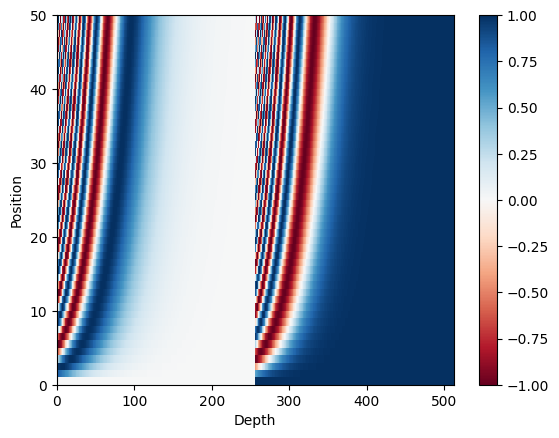

In [1273]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [1274]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  add_attention = tf.keras.layers.add([inputs,attention])
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([attention,outputs])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

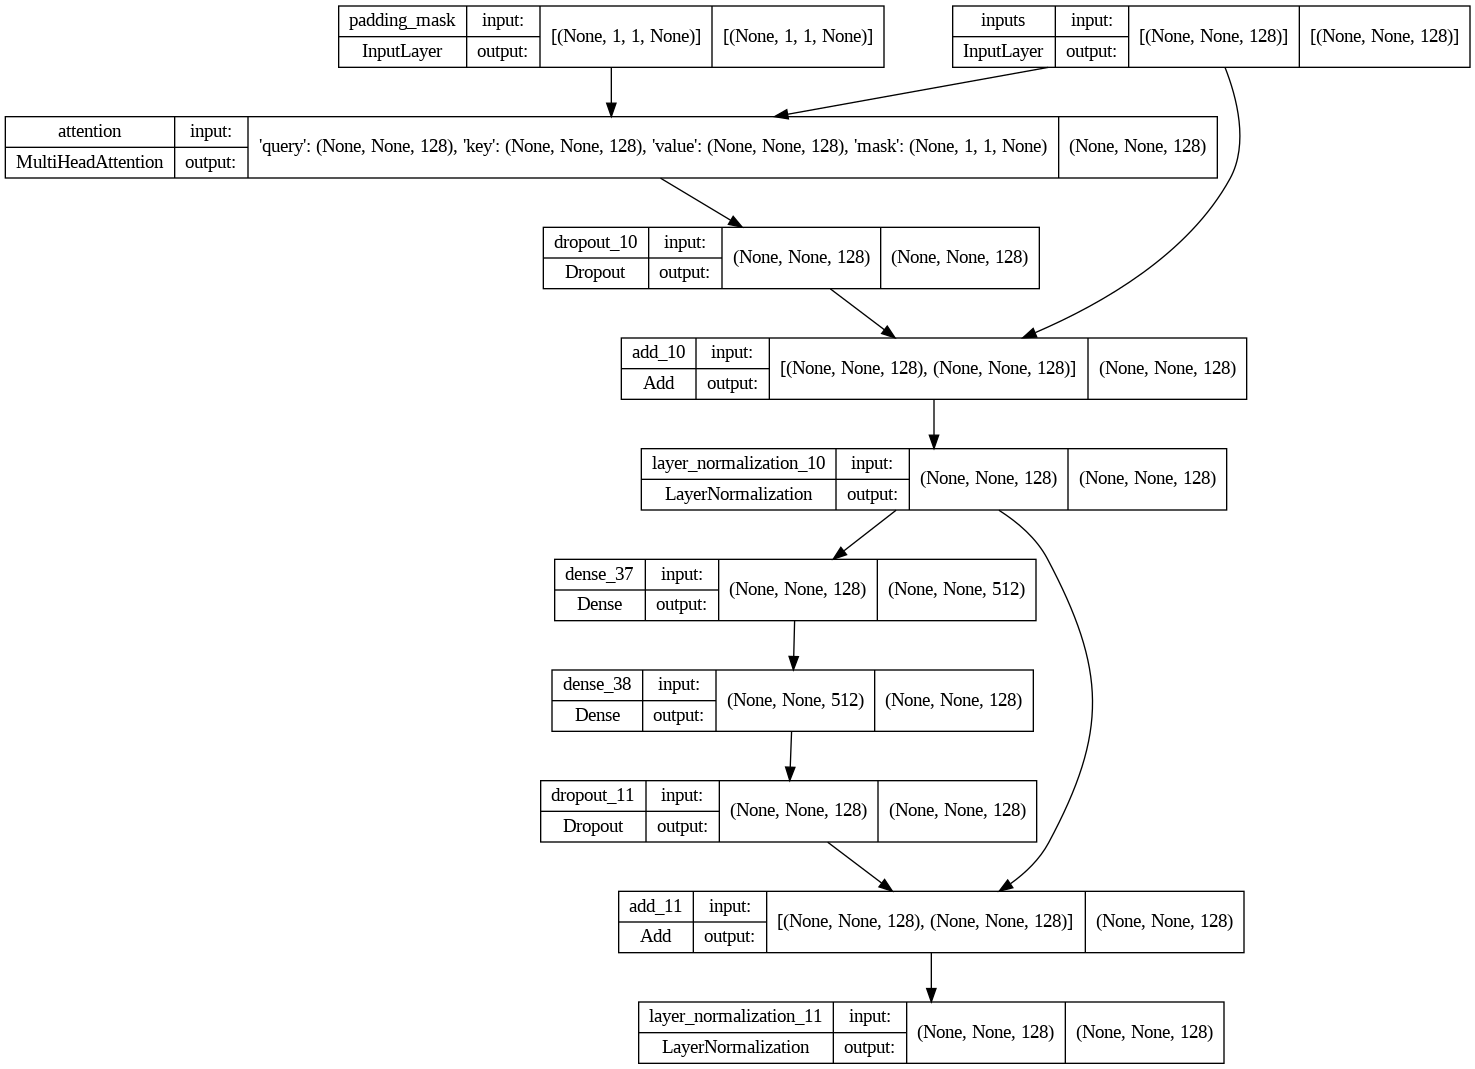

In [1275]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

In [1276]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.keras.layers.Lambda(lambda x: tf.math.sqrt(tf.cast(x, tf.float32)))(tf.cast(d_model, tf.float32))
  # Convert embeddings to dense tensor
  embeddings = tf.keras.layers.Dense(d_model)(embeddings) # Added line
  embeddings = PositionalEncoding(vocab_size,d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

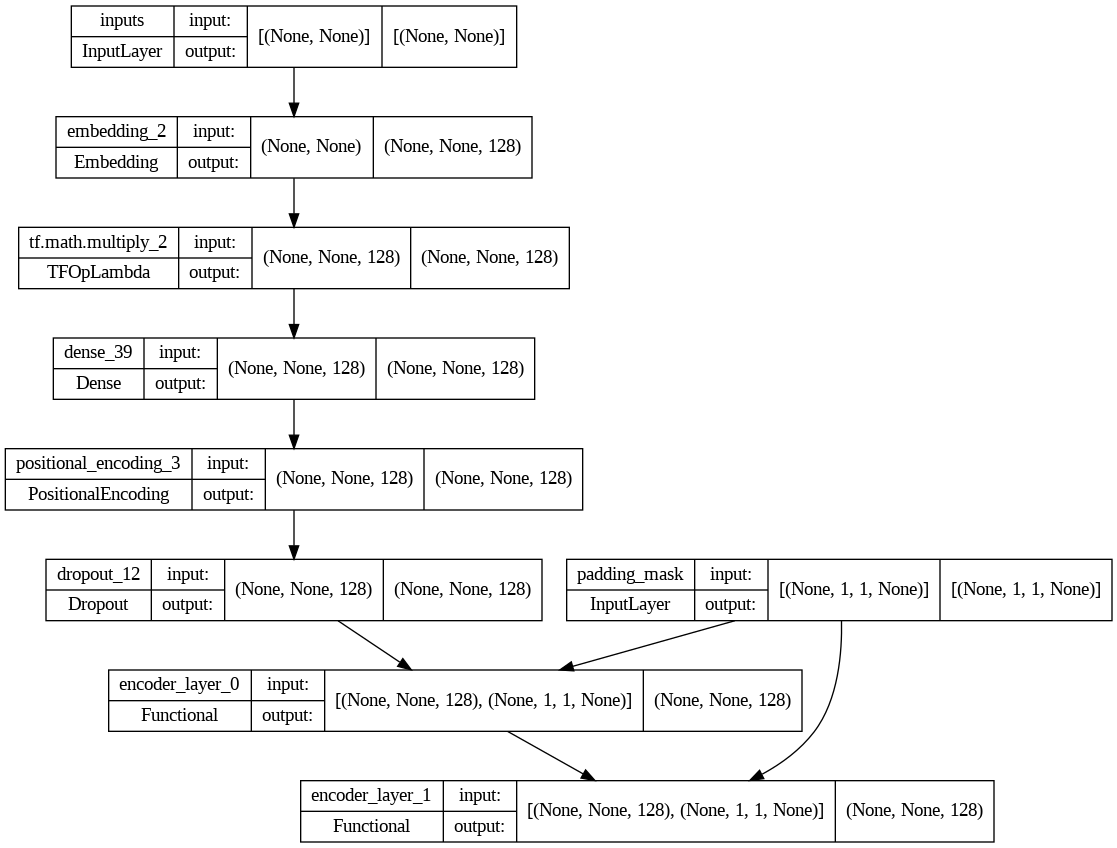

In [1277]:
sample_encoder = encoder(
    vocab_size=6000,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

In [1278]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  add_attention = tf.keras.layers.add([attention1,inputs])
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  add_attention = tf.keras.layers.add([attention2,attention1])
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([outputs,attention2])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

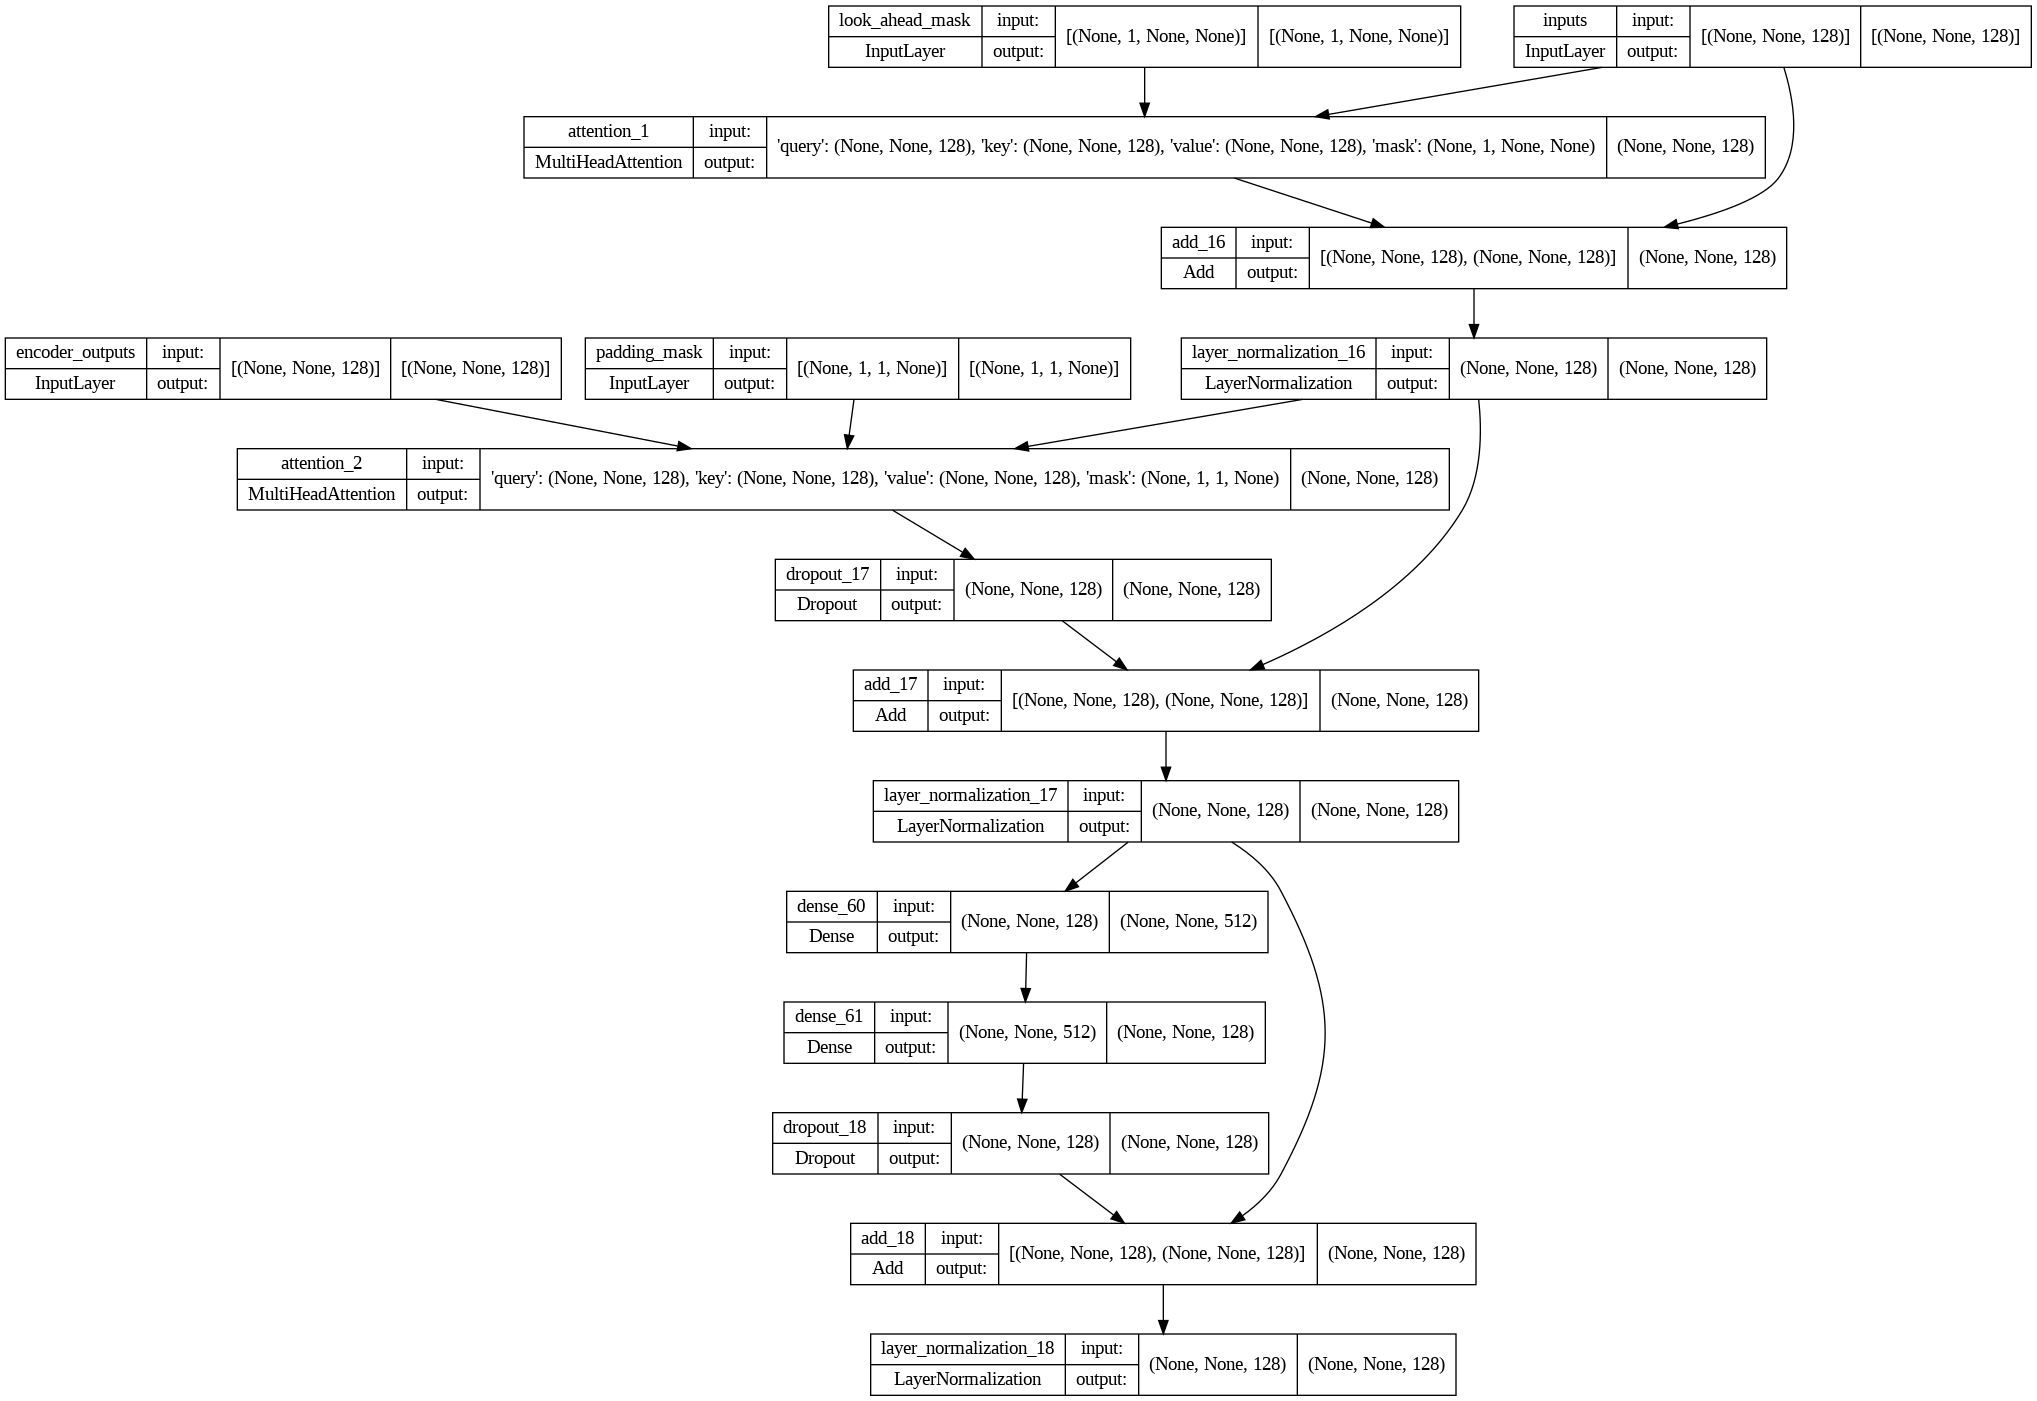

In [1279]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

In [1280]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  # Removed the keyword argument and pass d_model as an argument to the lambda function.
  embeddings *= tf.keras.layers.Lambda(lambda x: tf.math.sqrt(tf.cast(d_model, tf.float32)))(embeddings)
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

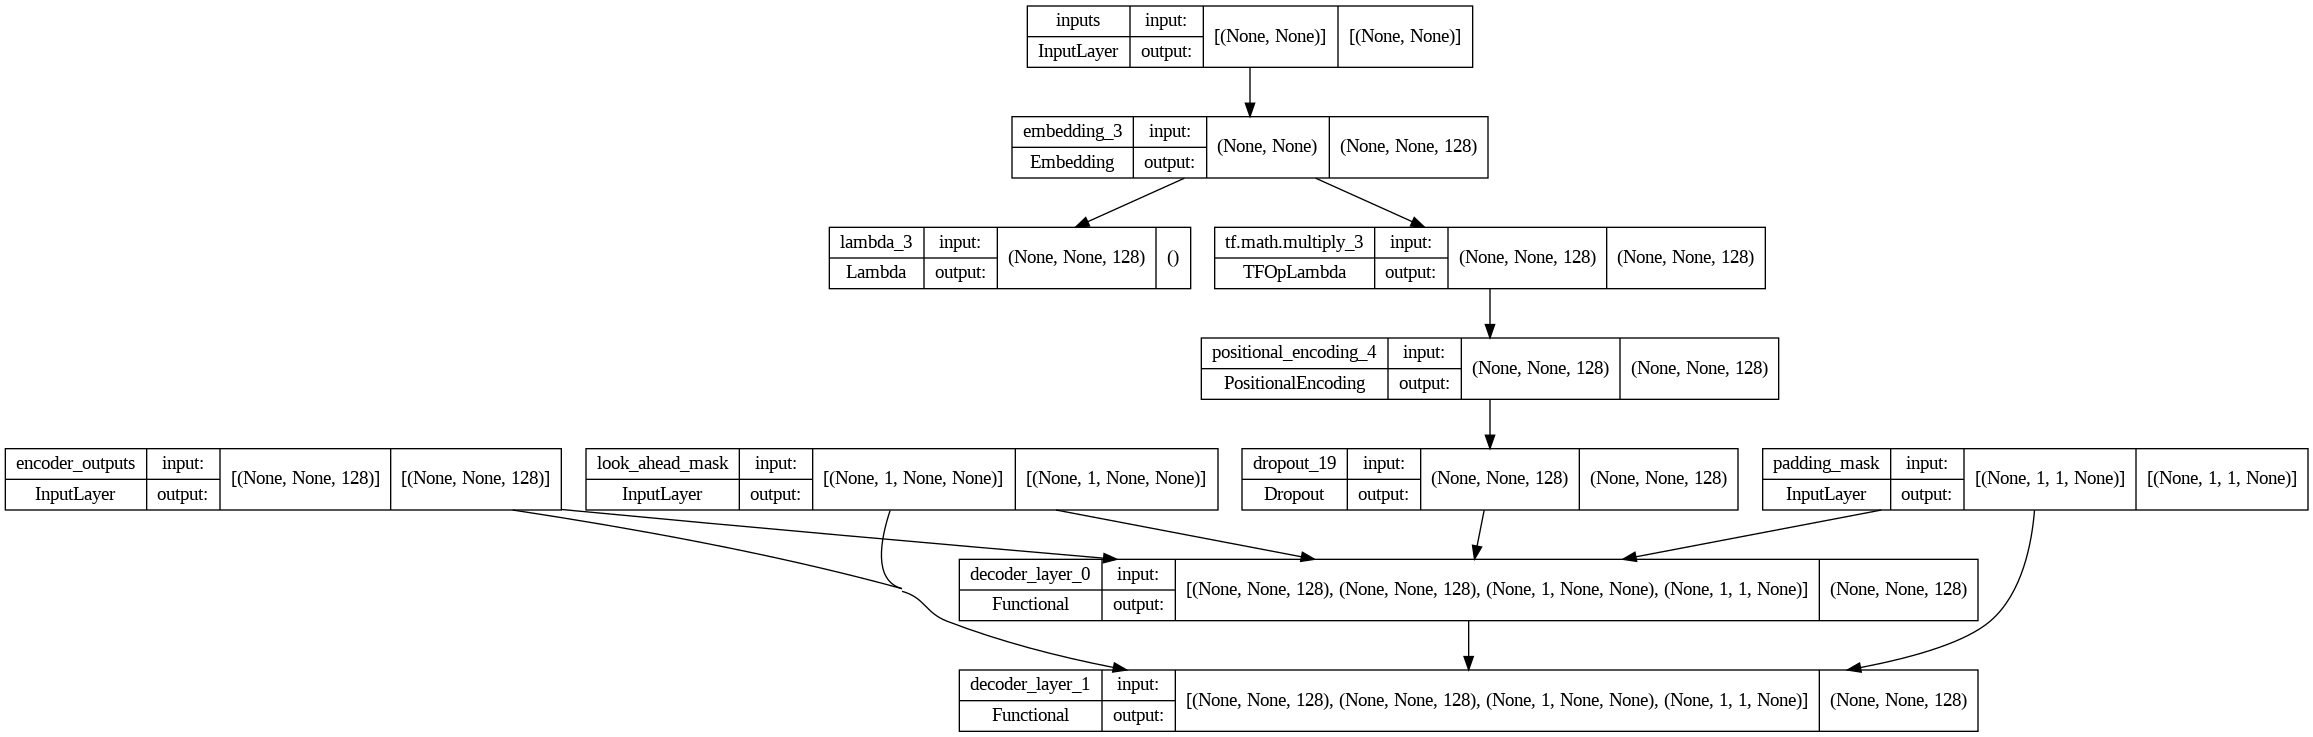

In [1281]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

In [1282]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

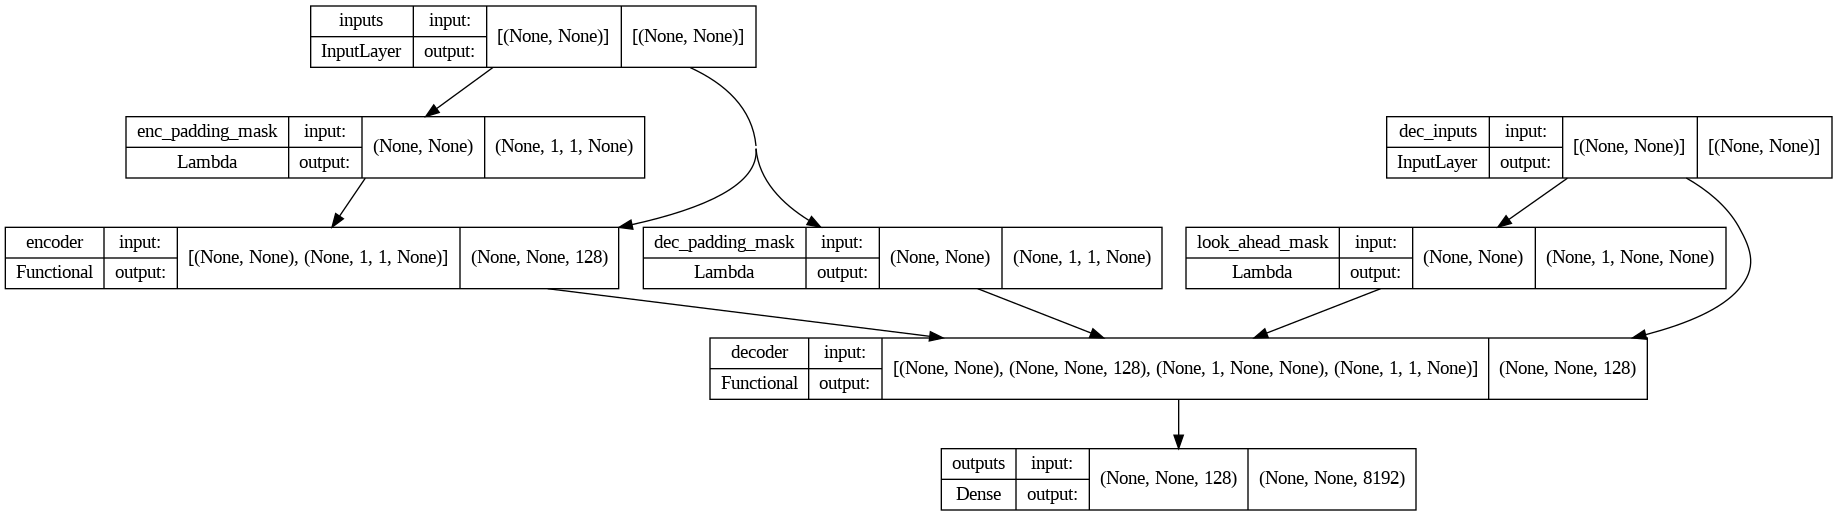

In [1283]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

In [1284]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  # Calculate the mean loss, excluding padded 0s
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)



In [1285]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=1000):
    super(CustomSchedule, self).__init__()

    self.d_model = tf.constant(d_model,dtype=tf.float32)
    self.warmup_steps = warmup_steps

  def get_config(self):
        return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

Text(0.5, 0, 'Train Step')

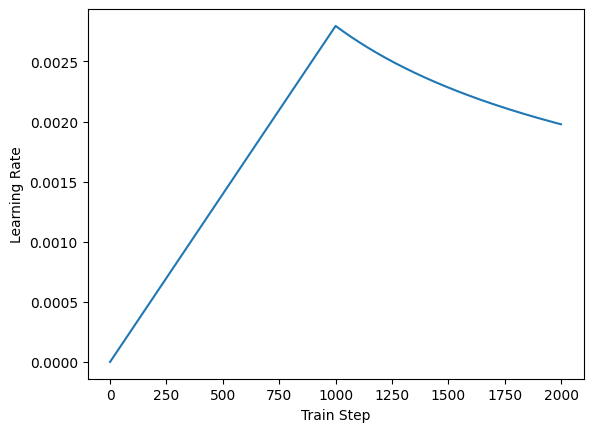

In [1286]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(2000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [1287]:
print(sample_learning_rate)

In [1288]:
# ipython-input-59-f54b9c5680b7
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

# Check if learning_rate is None
print(f"Learning rate: {learning_rate}")

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Check if optimizer is correctly instantiated
print(f"Optimizer: {optimizer}")

#Check the value of learning rate returned by CustomSchedule for a sample input
print(f"Learning rate for sample input: {learning_rate(tf.range(600, dtype=tf.float32))}")



def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strategy scope
with strategy.scope():
  model = transformer(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT)

  # Ensure model is compiled within the strategy scope
  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

  # Check if model is compiled correctly
  print(f"Model compiled: {model.optimizer}")

# Removed the conditional check as the model is compiled within the strategy scope
# Print model summary
model.summary()

Learning rate: <__main__.CustomSchedule object at 0x7c6237458280>
Optimizer: <keras.optimizer_v2.adam.Adam object at 0x7c6261ccff70>
Learning rate for sample input: [0.00000000e+00 1.39754252e-06 2.79508504e-06 4.19262733e-06
 5.59017008e-06 6.98771282e-06 8.38525466e-06 9.78279786e-06
 1.11803402e-05 1.25778824e-05 1.39754256e-05 1.53729670e-05
 1.67705093e-05 1.81680534e-05 1.95655957e-05 2.09631380e-05
 2.23606803e-05 2.37582226e-05 2.51557649e-05 2.65533090e-05
 2.79508513e-05 2.93483936e-05 3.07459341e-05 3.21434782e-05
 3.35410186e-05 3.49385627e-05 3.63361069e-05 3.77336473e-05
 3.91311914e-05 4.05287319e-05 4.19262760e-05 4.33238165e-05
 4.47213606e-05 4.61189047e-05 4.75164452e-05 4.89139893e-05
 5.03115298e-05 5.17090739e-05 5.31066180e-05 5.45041585e-05
 5.59017026e-05 5.72992431e-05 5.86967872e-05 6.00943313e-05
 6.14918681e-05 6.28894122e-05 6.42869563e-05 6.56845004e-05
 6.70820373e-05 6.84795814e-05 6.98771255e-05 7.12746696e-05
 7.26722137e-05 7.40697506e-05 7.54672947e

In [1289]:
start_time = time()

In [1]:
history = model.fit(train_dataset, validation_data= test_dataset, epochs=EPOCHS )

NameError: name 'model' is not defined

In [ ]:
training_time = time() - start_time

In [ ]:
# @title
y= 0.15
r= .02
#2DFaWc2QXjfvBqffih0ah8SFyhe_6Vt51s82egHmNKVbjfQZZ

In [ ]:
params_print = ["ACCURACY :"+ str(history.history['accuracy'][-1]),
                "VAL_ACCURACY :"+ str(history.history['val_accuracy'][-1]),
                "------ TRANSFORMER---------- :",
                "UNITS :"+ str(UNITS),
                "LAYERS :"+ str(NUM_LAYERS),
                "DROPOUT :"+ str(DROPOUT),
                "D_MODEL :"+ str(D_MODEL),
                "NUM_HEADS :"+ str(NUM_HEADS),
                "------ DATASET---------- :",
                "BATCH_SIZE :"+ str(BATCH_SIZE),
                "TRAINING_RATIO :"+ str(TRAINING_RATIO),
                "BUFFER_SIZE :"+ str(BUFFER_SIZE),
                "------ TRAINING---------- :",
                "EPOCHS:"+ str(EPOCHS),
                "TIME:"+ str(format(training_time,".3f")),
                "TIME:"+ str(training_time//60)+" m"+ str(training_time%60)+" s",
                "REPLICAS:"+ str(strategy.num_replicas_in_sync)
                ]

In [ ]:
ATTEMPT = 2
i = 0
for x in params_print:
  plt.text(43, y - r*i , x , fontsize=14 , horizontalalignment='left',verticalalignment='bottom')
  i += 1
# set other hyperparams also
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

fig1 = plt.gcf()
# fig1.savefig('graph.png', dpi=100)
plt.savefig( "graph" + '.png', bbox_inches='tight')

plt.show()
plt.draw()

#from google.colab import files
#files.download(str(ATTEMPT)+".png")

In [ ]:
ATTEMPT = 2
i = 0
for x in params_print:
  plt.text(43, y - r*i , x , fontsize=14 , horizontalalignment='left',verticalalignment='bottom')
  i += 1
# set other hyperparams also
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig1 = plt.gcf()
# fig1.savefig('graph.png', dpi=100)
plt.savefig( "graph" + '.png', bbox_inches='tight')

plt.show()
plt.draw()

#from google.colab import files
#files.download(str(ATTEMPT)+".png")

In [ ]:
filename = 'weights.weights.h5'
model.save_weights(filename)

In [ ]:
def evaluate(sentence):
  # sentence = preprocess_sentence(sentence)
  sentence = sinhala_pre.preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  # word_index = []
  prediction = evaluate(sentence).numpy()
  # print(prediction)
  # print(type(prediction))
  # predicted_sentence = ''
  predicted_sentence = tokenizer.decode(
       [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Indexes: {}'.format(prediction))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
predict('ඔයා විවාහ වෙන්නේ කවදද?')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
predict('මට විභාගයේදී ආතතියට පත් වන්නේ ඇයි?')

In [ ]:
predict('මානසික රෝගයක් තියෙනවා කියන්නේ මොකක්ද?')

In [ ]:
predict('මානසික රෝගයක් තියෙනවා කියන්නේ මොකක්ද?')